<a id="there_you_go_1"></a>
# 1) Exploring The Dataset

<a id="there_you_go_1.1"></a>
## 1.1) Importing Libraries

In [1]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math 
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.preprocessing import  Normalizer , scale
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler,  LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


In [2]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

<a id="there_you_go_1.2"></a>
## 1.2) Extract Dataset

In [3]:
train = pd.read_csv('/content/fashion-mnist_train.csv', error_bad_lines=False)
test = pd.read_csv('/content/fashion-mnist_test.csv', error_bad_lines=False)
df = train.copy()
df_test = test.copy()

In [4]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print('Train: ', df.shape)
print('Test: ', df_test.shape)

Train:  (60000, 785)
Test:  (10000, 785)


In [6]:
df.label.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

**Labels :**
* **0 - ** T-shirt/top
* **1 - ** Trouser
* **2 - ** Pullover
* **3 - ** Dress
* **4 - ** Coat
* **5 - ** Sandals
* **6 - ** Shirt
* **7 - ** Sneaker
* **8 - ** Bag
* **9 - ** Ankle Boots

In [7]:
# Train
df.isnull().any().sum()

0

In [8]:
# Test
df_test.isnull().any().sum()

0

<a id="there_you_go_2"></a>
# 2) Visualizing the Dataset

<a id="there_you_go_2.1"></a>
## 2.1) Plotting Random Images

In [9]:
# Mapping Classes
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

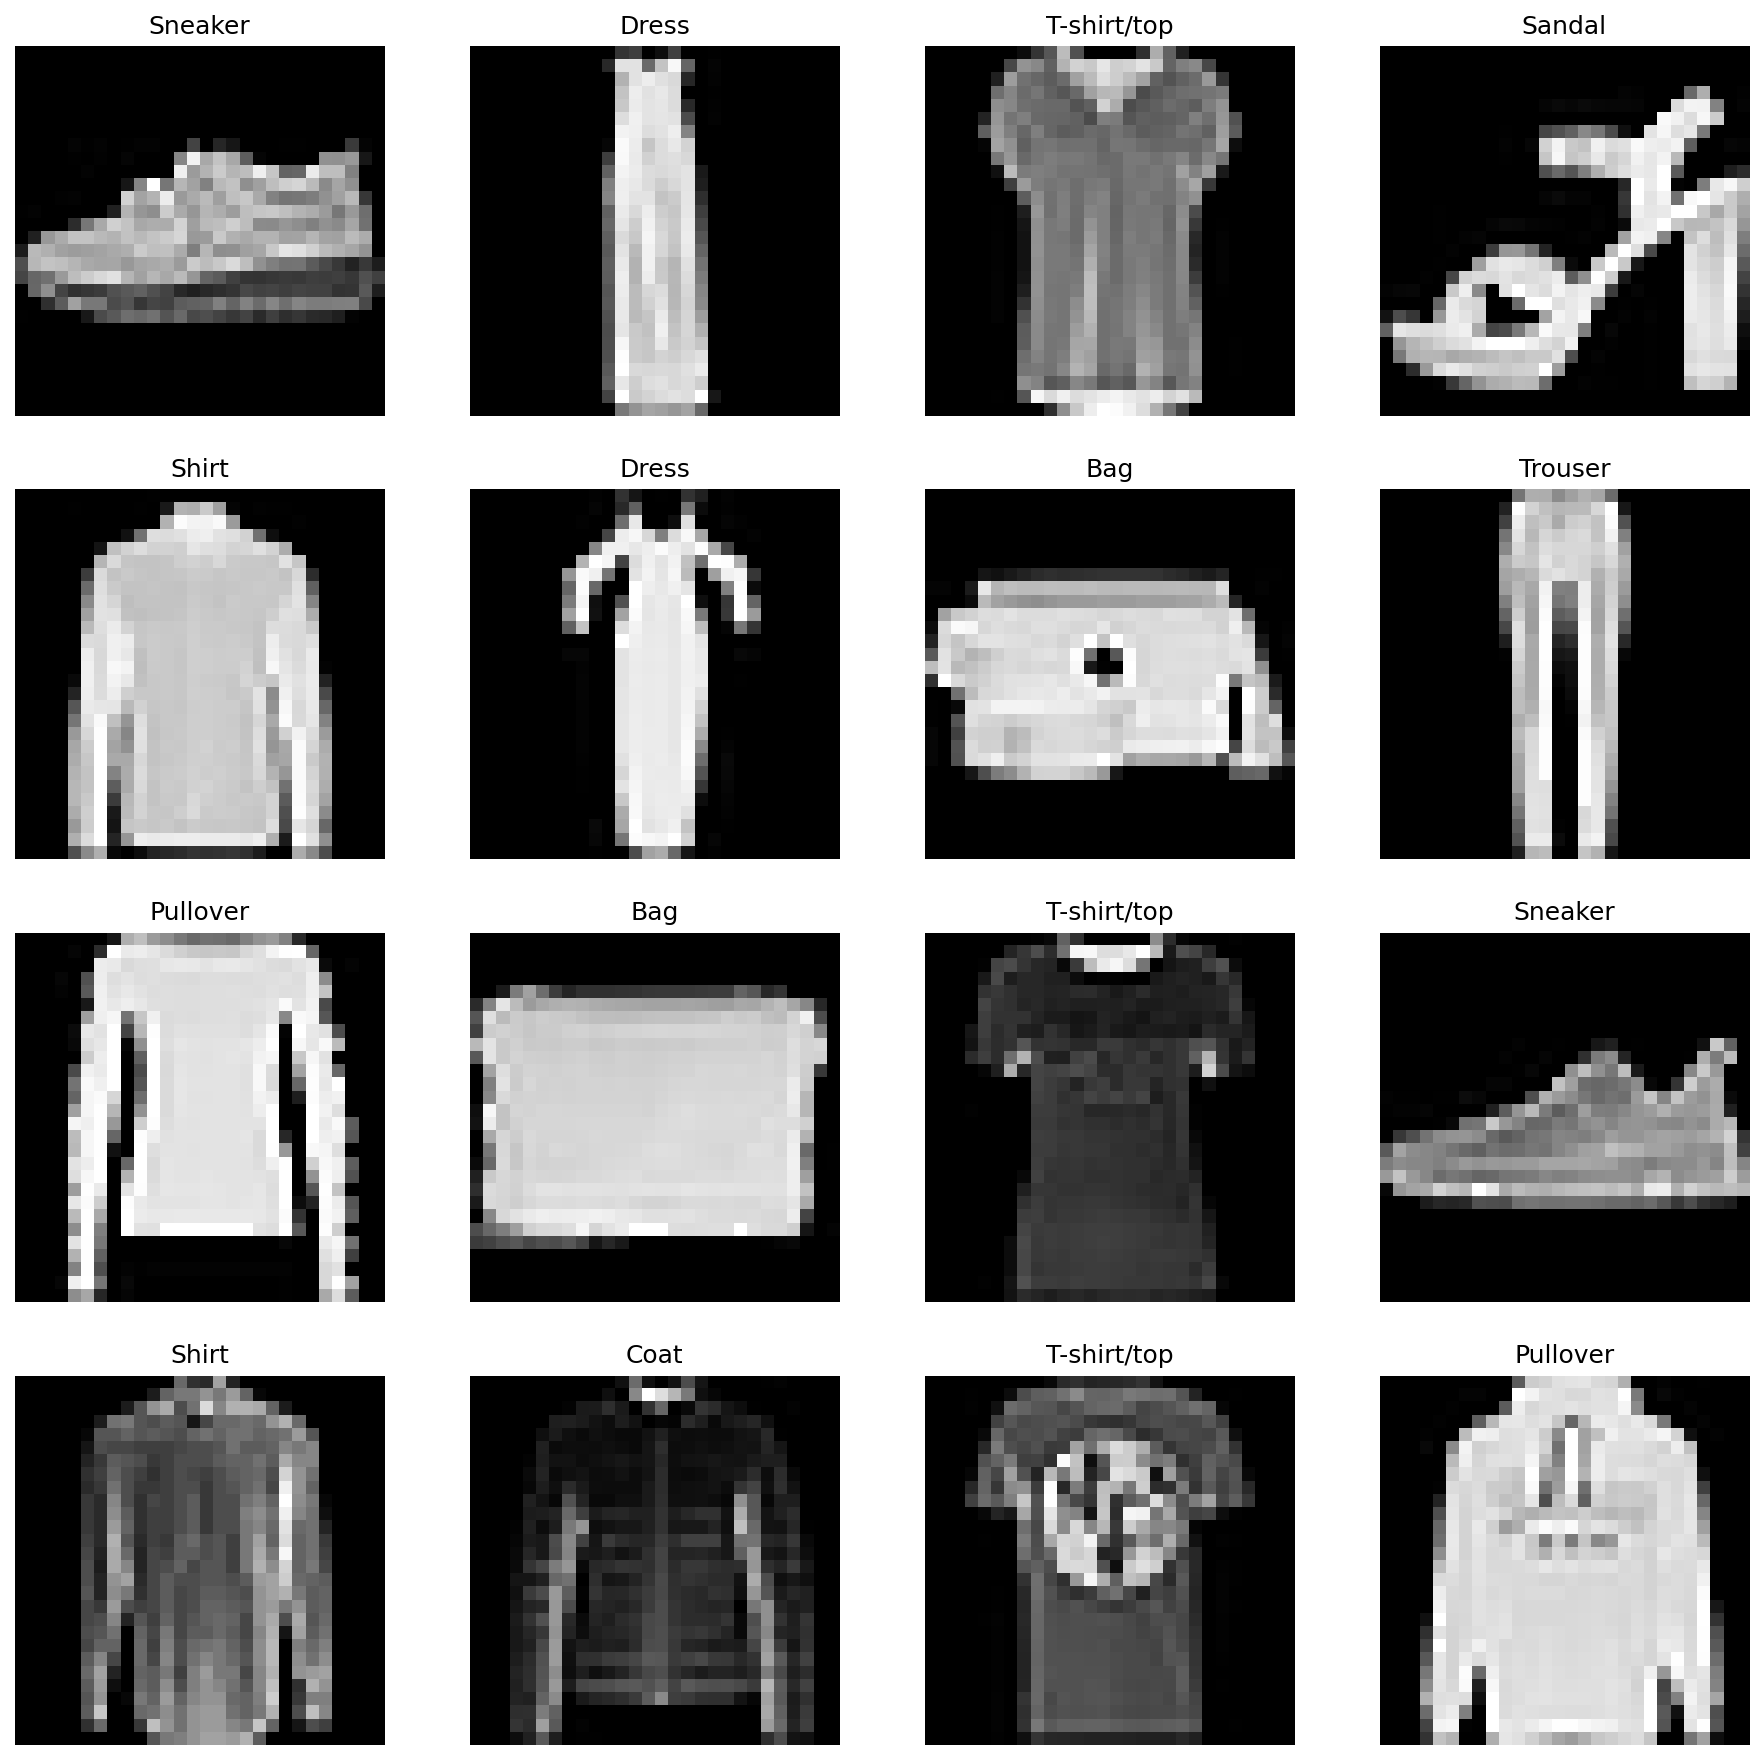

In [10]:
fig, axes = plt.subplots(4, 4, figsize = (15,15))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = df.drop('label', axis=1).values[index].reshape(28,28)
        cloths = df['label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

<a id="there_you_go_2.2"></a>
## 2.2) Distribution of Labels


In [11]:
df['label'].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

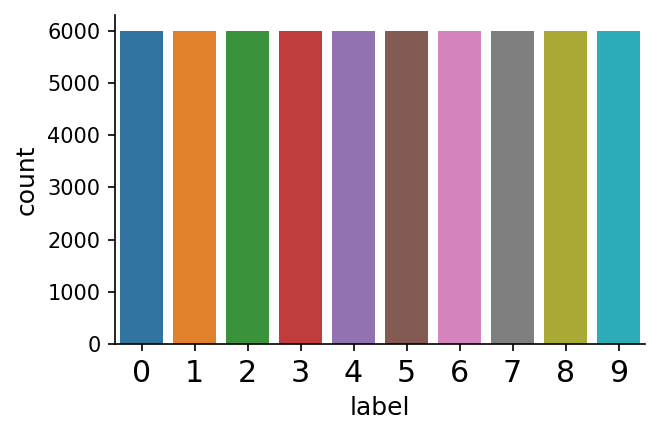

In [12]:
sns.factorplot(x='label', data=df, kind='count', size=3, aspect= 1.5)

<a id="there_you_go_3"></a>
# 3) Data PreProcessing

<a id="there_you_go_3.1"></a>
## 3.1) Setting Random Seeds

In [13]:
# Setting Random Seeds for Reproducibilty.
seed = 66
np.random.seed(seed)

<a id="there_you_go_3.2"></a>
## 3.2) Splitting Data into Train and Validation Set


In [14]:
X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

<a id="there_you_go_3.3"></a>
## 3.3) Reshaping the Images


In [15]:
# The first parameter in reshape indicates the number of examples.
# We pass it as -1, which means that it is an unknown dimension and we want numpy to figure it out.

# reshape(examples, height, width, channels)
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))

df_test.drop('label', axis=1, inplace=True)
df_test = df_test.values.reshape((-1, 28, 28, 1))

<a id="there_you_go_3.4"></a>
## 3.4) Normalization


In [16]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

<a id="there_you_go_3.5"></a>
## 3.5) One Hot Encoding


In [17]:
y_train1 = to_categorical(y_train, num_classes=10)
y_test1 = to_categorical(y_test, num_classes=10)

In [18]:
x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float64')/255
x_test = x_test.reshape(x_test.shape[0],28,28,1).astype('float64')/255

In [19]:
print(y_train.shape)
print(y_test.shape)

(54000,)
(6000,)


<a id="there_you_go_4"></a>
# 4) Training ANN/DNN

<a id="there_you_go_4.1"></a>
## 4.1) Building a ANN/DNN

In [20]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()
model = None
model = Sequential()
model.add(Flatten(input_shape = (28,28))) ## Flatten converts the shape of 2D image array into 1D array(28*28 = 784)
model.add(Dense(128,activation = 'relu')) # First Hidden Layer
model.add(Dense(10)) # Output Layer

<a id="there_you_go_4.2"></a>
## 4.2) Compiling the Model


In [21]:
model.compile(optimizer = 'adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),metrics = ['accuracy'])

<a id="there_you_go_4.3"></a>
## 4.3) Model Summary

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


<a id="there_you_go_4.4"></a>
## 4.4) Fitting the Model

In [23]:
model.fit(x_train,y_train,epochs = 30)

Epoch 1/30
1688/1688 [==============================] - 6s 2ms/step - loss: 1.1131 - accuracy: 0.6660
Epoch 2/30
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6548 - accuracy: 0.7641
Epoch 3/30
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5803 - accuracy: 0.7905
Epoch 4/30
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5380 - accuracy: 0.8076
Epoch 5/30
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5110 - accuracy: 0.8180
Epoch 6/30
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4904 - accuracy: 0.8268
Epoch 7/30
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4750 - accuracy: 0.8320
Epoch 8/30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.4625 - accuracy: 0.8360
Epoch 9/30
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4520 - accuracy: 0.8401
Epoch 10/30
1688/1688 [==============================] - 5s 3ms/step - loss: 0.443

In [24]:
score = model.evaluate(x_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

188/188 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8728
Loss: 0.3719
Accuracy: 0.8728


<a id="there_you_go_5"></a>
# 5) Training a Convolutional Neural Network

<a id="there_you_go_5.1"></a>
## 5.1) Building a ConvNet

In [ ]:
# Building a ConvNet
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
    
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

<a id="there_you_go_5.2"></a>
## 5.2) Compiling the Model


In [ ]:
# Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

In [ ]:
# Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

<a id="there_you_go_5.3"></a>
## 5.3) Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        1

<a id="there_you_go_5.4"></a>
## 5.4) Learning Rate Decay


In [ ]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

<a id="there_you_go_5.5"></a>
## 5.5) Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 8,  
        zoom_range = 0.1,  
        shear_range = 0.3,  
        width_shift_range=0.08,  
        height_shift_range=0.08,  
        vertical_flip=True)  

In [ ]:
datagen.fit(x_train)

<a id="there_you_go_5.6"></a>
## 5.6) Fitting the Model

In [ ]:
batch_size = 128
epochs = 40

In [ ]:
# Fit the Model
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])

Epoch 1/40
421/421 - 16s - loss: 0.3184 - accuracy: 0.8846 - val_loss: 0.2483 - val_accuracy: 0.9107 - lr: 0.0010 - 16s/epoch - 38ms/step
Epoch 2/40
421/421 - 16s - loss: 0.3153 - accuracy: 0.8870 - val_loss: 0.2620 - val_accuracy: 0.9018 - lr: 9.0000e-04 - 16s/epoch - 38ms/step
Epoch 3/40
421/421 - 16s - loss: 0.3006 - accuracy: 0.8919 - val_loss: 0.2292 - val_accuracy: 0.9142 - lr: 8.1000e-04 - 16s/epoch - 38ms/step
Epoch 4/40
421/421 - 16s - loss: 0.2935 - accuracy: 0.8945 - val_loss: 0.2196 - val_accuracy: 0.9215 - lr: 7.2900e-04 - 16s/epoch - 38ms/step
Epoch 5/40
421/421 - 16s - loss: 0.2849 - accuracy: 0.8979 - val_loss: 0.2261 - val_accuracy: 0.9163 - lr: 6.5610e-04 - 16s/epoch - 38ms/step
Epoch 6/40
421/421 - 16s - loss: 0.2794 - accuracy: 0.8996 - val_loss: 0.2085 - val_accuracy: 0.9213 - lr: 5.9049e-04 - 16s/epoch - 38ms/step
Epoch 7/40
421/421 - 16s - loss: 0.2700 - accuracy: 0.9021 - val_loss: 0.2017 - val_accuracy: 0.9260 - lr: 5.3144e-04 - 16s/epoch - 38ms/step
Epoch 8/40

In [ ]:
score = model.evaluate(x_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

188/188 [==============================] - 1s 4ms/step - loss: 0.1762 - accuracy: 0.9370
Loss: 0.1762
Accuracy: 0.9370


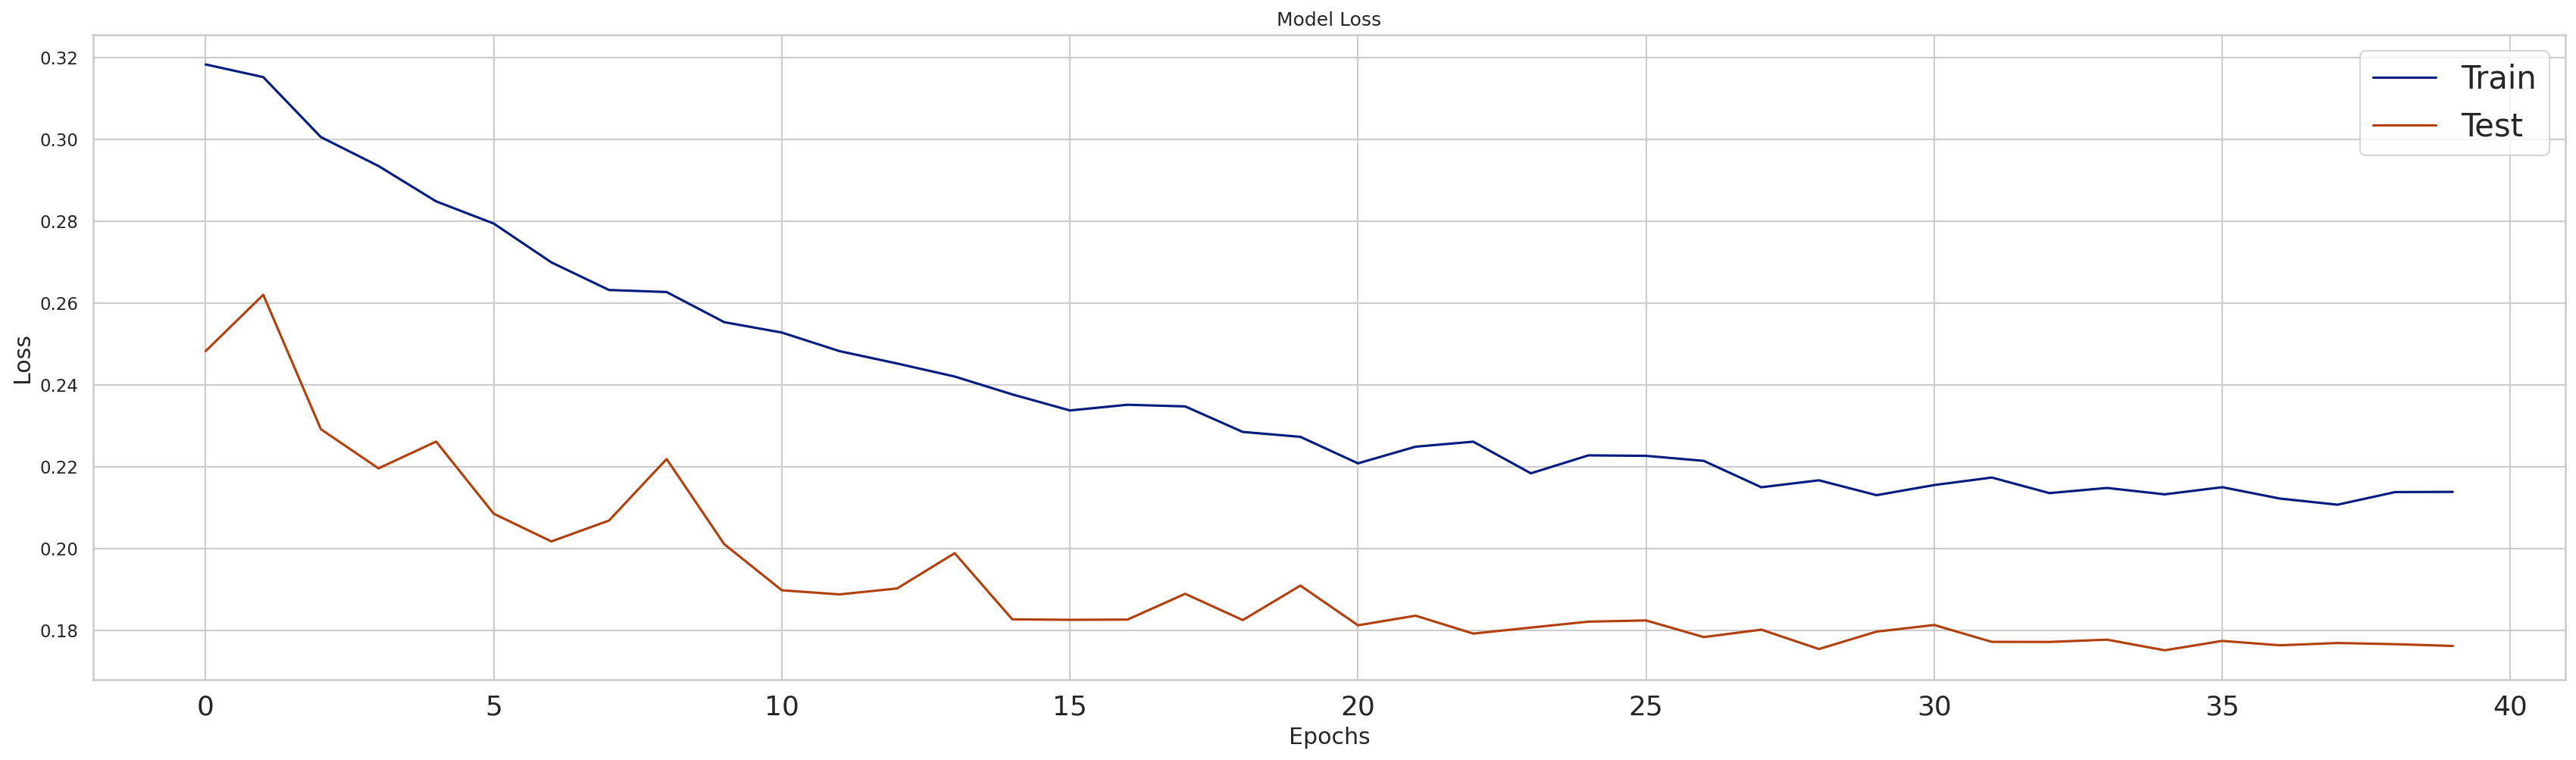

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

<a id="there_you_go_6"></a>
# 6) Confusion Matrix


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

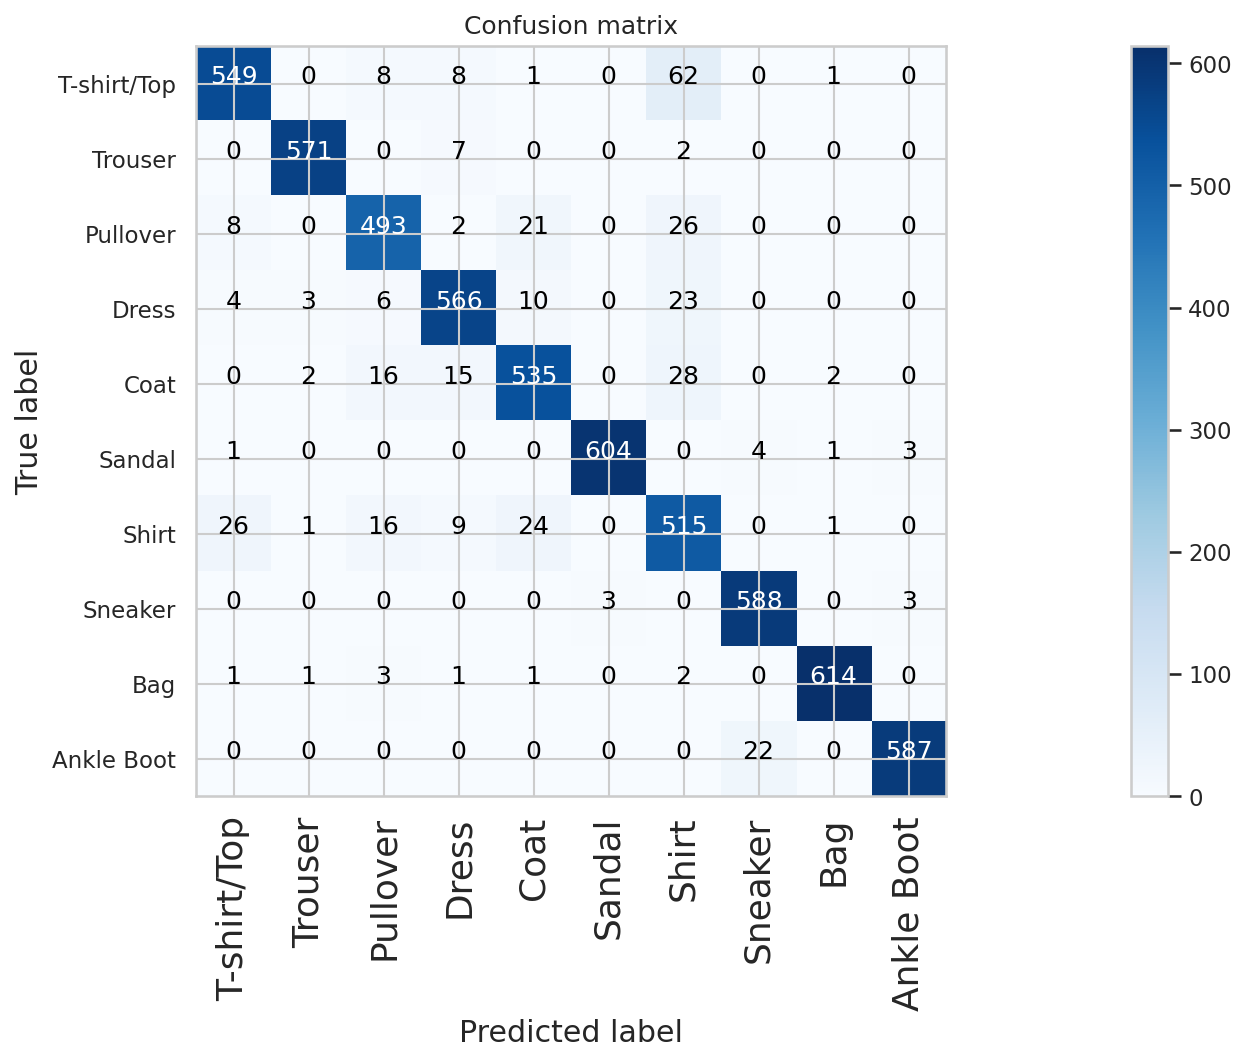

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

<a id="there_you_go_7"></a>
# 7) Visualization of Predicted Classes

In [ ]:
correct = []
for i in range(len(y_test)):
    if(Y_pred_classes[i] == Y_true[i]):
        correct.append(i)
    if(len(correct) == 4):
        break

Text(0.5, 1.0, 'Predicted Label : Sandal\nActual Label : Sandal')

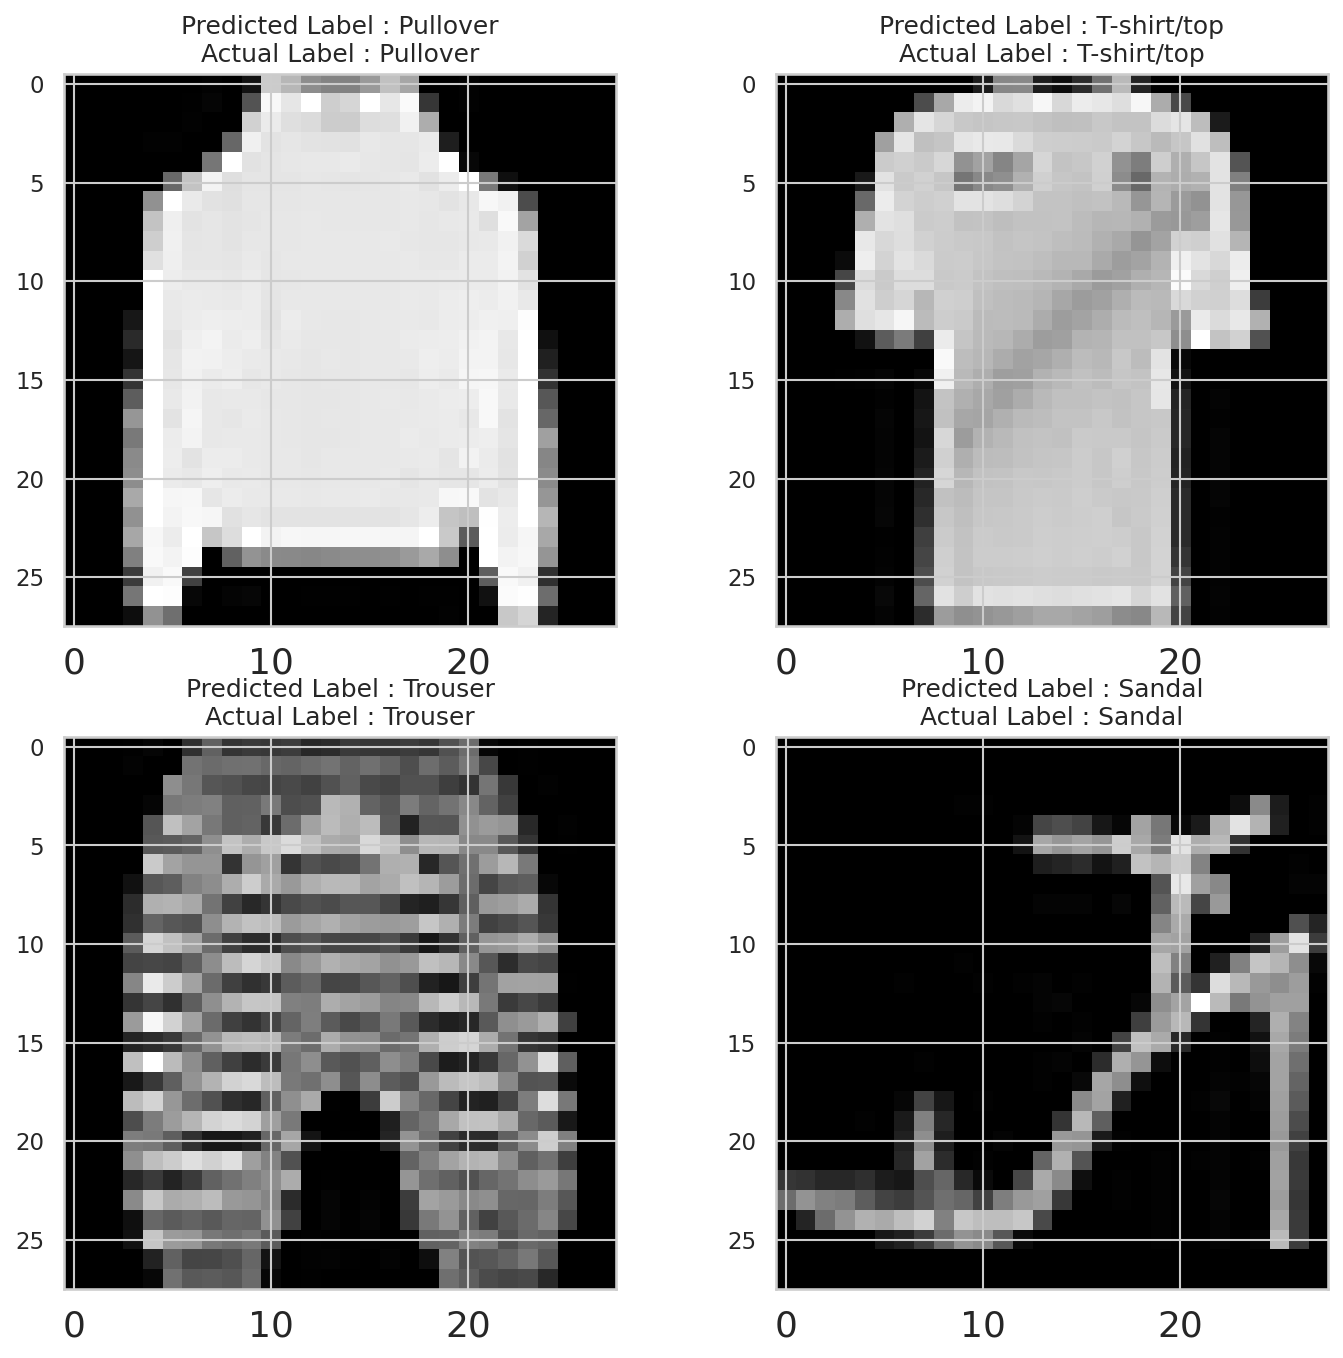

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
ax[0,0].imshow(x_test[correct[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[0]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[0]]]))
ax[0,1].imshow(x_test[correct[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[1]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[1]]]))
ax[1,0].imshow(x_test[correct[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[2]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[2]]]))
ax[1,1].imshow(x_test[correct[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[3]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[3]]]))

<a id="there_you_go_8"></a>
# 8) Classification Report


In [ ]:
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.93      0.87      0.90       629
     Trouser       0.99      0.98      0.99       580
    Pullover       0.91      0.90      0.90       550
       Dress       0.93      0.92      0.93       612
        Coat       0.90      0.89      0.90       598
      Sandal       1.00      0.99      0.99       613
       Shirt       0.78      0.87      0.82       592
     Sneaker       0.96      0.99      0.97       594
         Bag       0.99      0.99      0.99       623
  Ankle Boot       0.99      0.96      0.98       609

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



# 9) Predicting on the Test Data
Let's Evaluate the Models performance on the Test Data.

In [ ]:
X = df_test
Y = to_categorical(test.iloc[:,0])

In [ ]:
score = model.evaluate(X, Y)

print("Loss: {:.4f}".format(score[0]))
print("Accuracy: {:.4f}".format(score[1]))

429/429 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.9365
Loss: nan
Accuracy: 0.9365
